# Training file for RDN

## Imports

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import src.nntools as nt
from src.CarlaDataset import CarlaDataset, CarlaDatasetPatch
import skimage.metrics as metrics
import platform  # Import the platform module to detect the OS

device = None
if platform.system() == 'Windows':  # Check if the OS is Windows
    import torch_directml  # Import torch_directml only on Windows
    device = torch_directml.device()


if not device:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')

from src.rdn import RDN

print(device)

cuda


# Utility function

In [2]:
class SuperResolutionStatsManager(nt.StatsManager):
    def __init__(self):
        super(SuperResolutionStatsManager, self).__init__()

    def init(self):
        super(SuperResolutionStatsManager, self).init()
        # Initializing `self.running_psnr`
        self.running_psnr = 0
        self.running_ssim = 0

    def accumulate(self, loss, x, y, d):
        super(SuperResolutionStatsManager, self).accumulate(loss, x, y, d)
        # Updating `self.running_psnr`
        d_numpy = d.detach().to('cpu').numpy()
        y_numpy = y.detach().to('cpu').numpy()

        self.running_psnr += metrics.peak_signal_noise_ratio(d_numpy, y_numpy)

        current_ssim = 0

        for i in range(d_numpy.shape[0]):
            d_numpy_temp = np.moveaxis(d_numpy[i], [0, 1, 2], [2, 0, 1])
            y_numpy_temp = np.moveaxis(y_numpy[i], [0, 1, 2], [2, 0, 1])

            value_range = max(d_numpy_temp.max(), y_numpy_temp.max()) - min(d_numpy_temp.min(), y_numpy_temp.min())
            
            current_ssim += metrics.structural_similarity(d_numpy_temp, y_numpy_temp, win_size=7, data_range=value_range, multichannel=True, channel_axis=2)
        
        self.running_ssim += current_ssim / d_numpy.shape[0]

    def summarize(self):
        loss = super(SuperResolutionStatsManager, self).summarize()
        psnr = self.running_psnr / (self.number_update+1e-9 )
        ssim = self.running_ssim / (self.number_update+1e-9 )
        return {'loss': loss, 'psnr': psnr, "ssim": ssim}

def criterion(y, d):
    return F.mse_loss(y, d)

#show image
def myimshow(image, ax=plt):
    image = image.detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    # ax.axis('off')
    return h

## Data loader

In [3]:
new_img_size = 256
common_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    common_transform,
    #transforms.RandomRotation(degrees=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #transforms.RandomResizedCrop(size=(new_img_size, new_img_size), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
])

valid_transform = transforms.Compose([
    common_transform,
    #transforms.CenterCrop((new_img_size, new_img_size)),
])

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#import your datasetclass

PATCH_SIZE = 32

full_train = CarlaDataset("1920x1080", "960x540", "train", transforms=train_transform, download=True)

X_train = CarlaDatasetPatch("1920x1080", "960x540", "train", transforms=train_transform, download=True, patch_size=PATCH_SIZE)
X_valid = CarlaDatasetPatch("1920x1080", "960x540", "test", transforms=train_transform, download=True, patch_size=PATCH_SIZE)

SUBSET_SIZE = 4000
if len(X_train) > SUBSET_SIZE:
    X_train.limit_dataset(SUBSET_SIZE)

print("Size of x_train", len(X_train))

Dataset already present
Dataset already present
Dataset already present
Size of x_train 4000


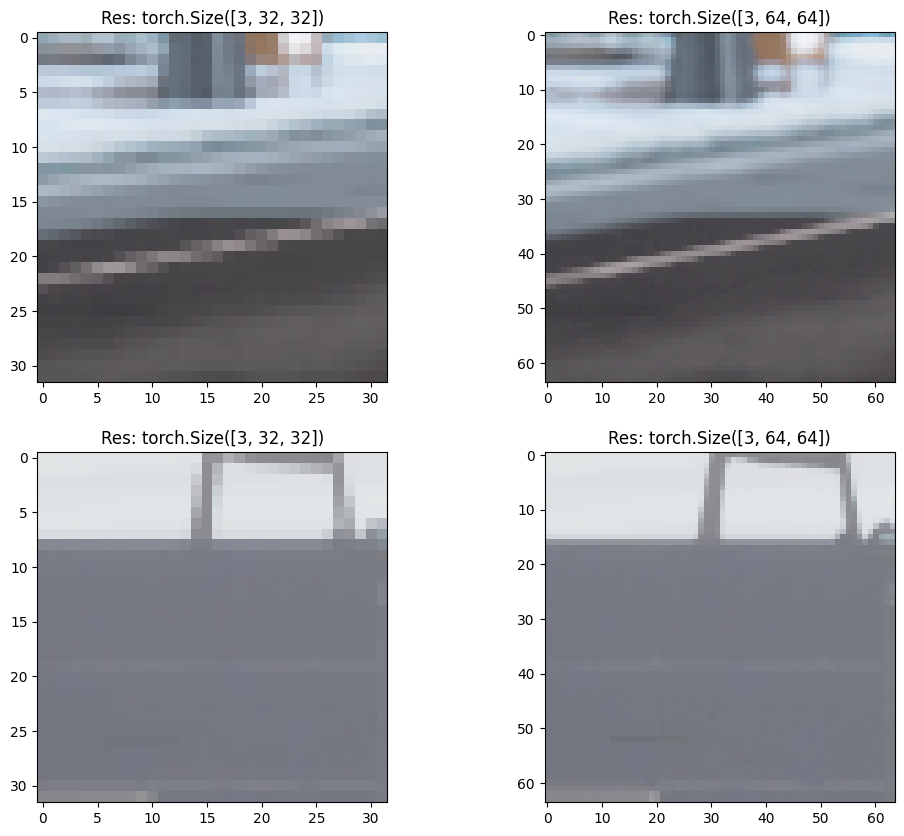

In [5]:
#printing some 2 pairs of low res/high res images
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
ex_low_res1, ex_high_res1 = X_train[np.random.randint(len(X_train))]
ex_low_res2, ex_high_res2 = X_train[np.random.randint(len(X_train))]
ex = [ex_low_res1, ex_high_res1, ex_low_res2, ex_high_res2]
for i, ax in enumerate(axes.flat):
    ax.set_title(f'Res: {ex[i].shape}')
    myimshow(ex[i], ax=ax)

In [6]:
# Plot for the the predicted image, low resolution image and high resolution image in first row
# plot Plot the loss, psnr and ssim curves in the second row
def plot_images_and_metrics(exp, fig, axes, dataset, index): ##Only to use when perform_validation_during_training == True
    low_res, high_res = dataset[index]

    with torch.no_grad():
        predicted_res = exp.net(low_res.to(device))[0]

    axes[0][0].clear()
    axes[0][1].clear()
    axes[0][2].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    axes[1][2].clear()

    axes[0][0].set_title(f'Low res: {low_res.detach().cpu().numpy().shape}')
    axes[0][1].set_title(f'High res: {high_res.detach().cpu().numpy().shape}')
    axes[0][2].set_title(f'Predicted res: {predicted_res.detach().cpu().numpy().shape}')

    axes[0][0].imshow(low_res.detach().cpu().numpy().transpose(1, 2, 0))
    axes[0][1].imshow(high_res.detach().cpu().numpy().transpose(1, 2, 0))
    axes[0][2].imshow(predicted_res.detach().cpu().numpy().transpose(1, 2, 0))

    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="Train loss")
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="Train psnr")
    axes[1][2].plot([exp.history[k][0]['ssim'] for k in range(exp.epoch)], label="Train ssim")

    axes[1][0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="Eval loss")
    axes[1][1].plot([exp.history[k][1]['psnr'] for k in range(exp.epoch)], label="Eval psnr")
    axes[1][2].plot([exp.history[k][1]['ssim'] for k in range(exp.epoch)], label="Eval ssim")

    axes[1][0].legend()
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Loss")        
    axes[1][1].legend()
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("PSNR") 
    axes[1][2].legend()
    axes[1][2].set_xlabel("Epoch")
    axes[1][2].set_ylabel("SSIM")

## Experiment on a small batch

In [7]:
small_dataset_size = 10
small_dataset = [X_train[np.random.randint(len(X_train))] for _ in range(small_dataset_size)]

small_train_size = int(0.8 * len(small_dataset))
small_valid_size = len(small_dataset) - small_train_size
small_train_dataset, small_valid_dataset = torch.utils.data.random_split(small_dataset, [small_train_size, small_valid_size])

print("Size of small_train_dataset: ", len(small_train_dataset))

Size of small_train_dataset:  8


In [8]:
lr = 1e-3
r = RDN(C=6 , D=20, G=64, G0=64, scaling_factor=2, kernel_size=3, c_dims=X_train[0][0].shape[0], upscaling='shuffle', weights=None)
torch.cuda.empty_cache()
r = r.to(device)
# In mega bytes
print("Size of model mb", sum(p.numel() for p in r.parameters() if p.requires_grad) / (1024 * 1024))
# Size of batch in mega bytes
print("Size of batch mb", small_dataset[0][0].shape[0] * small_dataset[0][0].shape[1] * small_dataset[0][0].shape[2] * 4 / (1024 * 1024))

adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
path = "results/smallbatchexperiement4"
exp = nt.Experiment(r, small_dataset, small_valid_dataset, adam, stats_manager, device, criterion, batch_size=1,
                     output_dir=path, perform_validation_during_training=True)

Size of model mb 15.593994140625
Size of batch mb 0.01171875


Start/Continue training from epoch 300
Finish training for 300 epochs


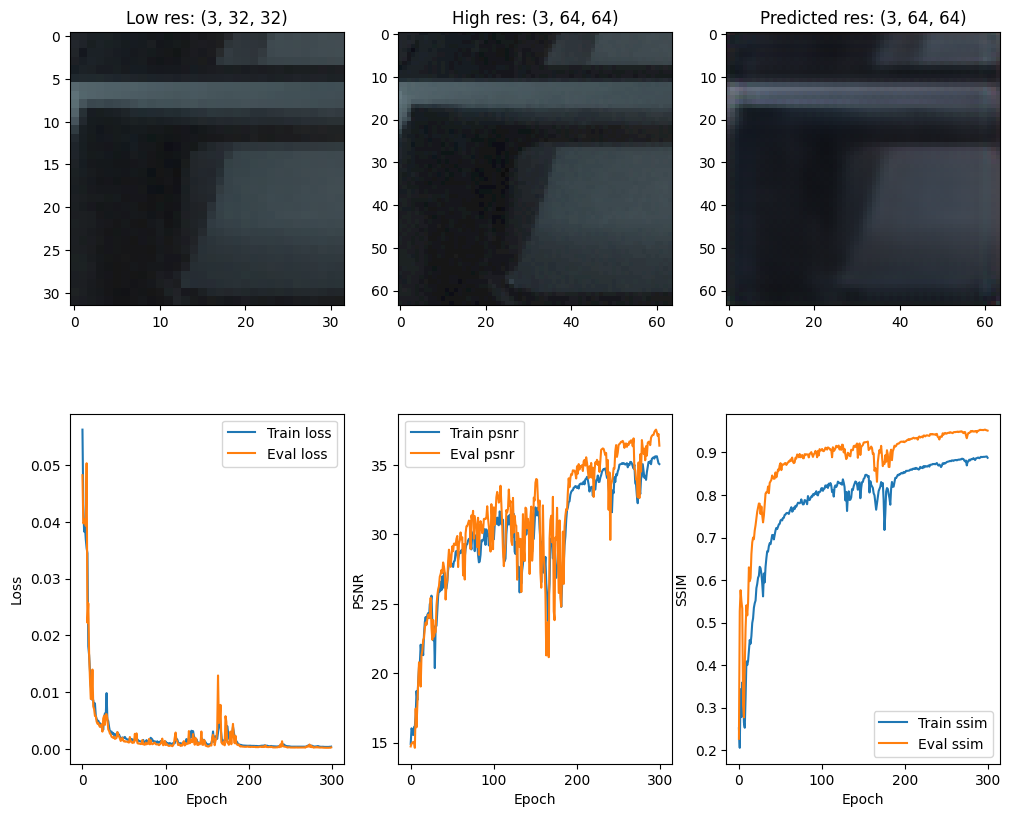

In [9]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 10))
exp.run(num_epochs=300, plot=lambda exp: plot_images_and_metrics(exp, fig, axes, small_valid_dataset, np.random.randint(len(small_valid_dataset))))

In [10]:
# Show three images for a set and predict it
def plot_images_from_model(model, dataset, num_images=1, indices=None):
    images = []

    num_images = max(num_images, len(indices) if indices else 0)

    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    print(num_images)

    for i in range(num_images):
        if indices:
            low_res, high_res = dataset[indices[i]]
            print("Chosen index", indices[i])
        else:
            index = np.random.randint(len(dataset))
            low_res, high_res = dataset[index]
            print("Chosen index", index)

        images.append(low_res)
        images.append(high_res)

        with torch.no_grad():
            predicted_res = model.net(low_res.to(device))[0]

        images.append(predicted_res)

        axes[i, 0].set_title(f'Low res: {low_res.detach().cpu().numpy().shape}')
        axes[i, 1].set_title(f'High res: {high_res.detach().cpu().numpy().shape}')
        axes[i, 2].set_title(f'Predicted res: {predicted_res.detach().cpu().numpy().shape}')

        axes[i, 0].imshow(low_res.detach().cpu().numpy().transpose(1, 2, 0))
        axes[i, 1].imshow(high_res.detach().cpu().numpy().transpose(1, 2, 0))
        axes[i, 2].imshow(predicted_res.detach().cpu().numpy().transpose(1, 2, 0))
    
    plt.show()


3
Chosen index 0
Chosen index 1
Chosen index 2


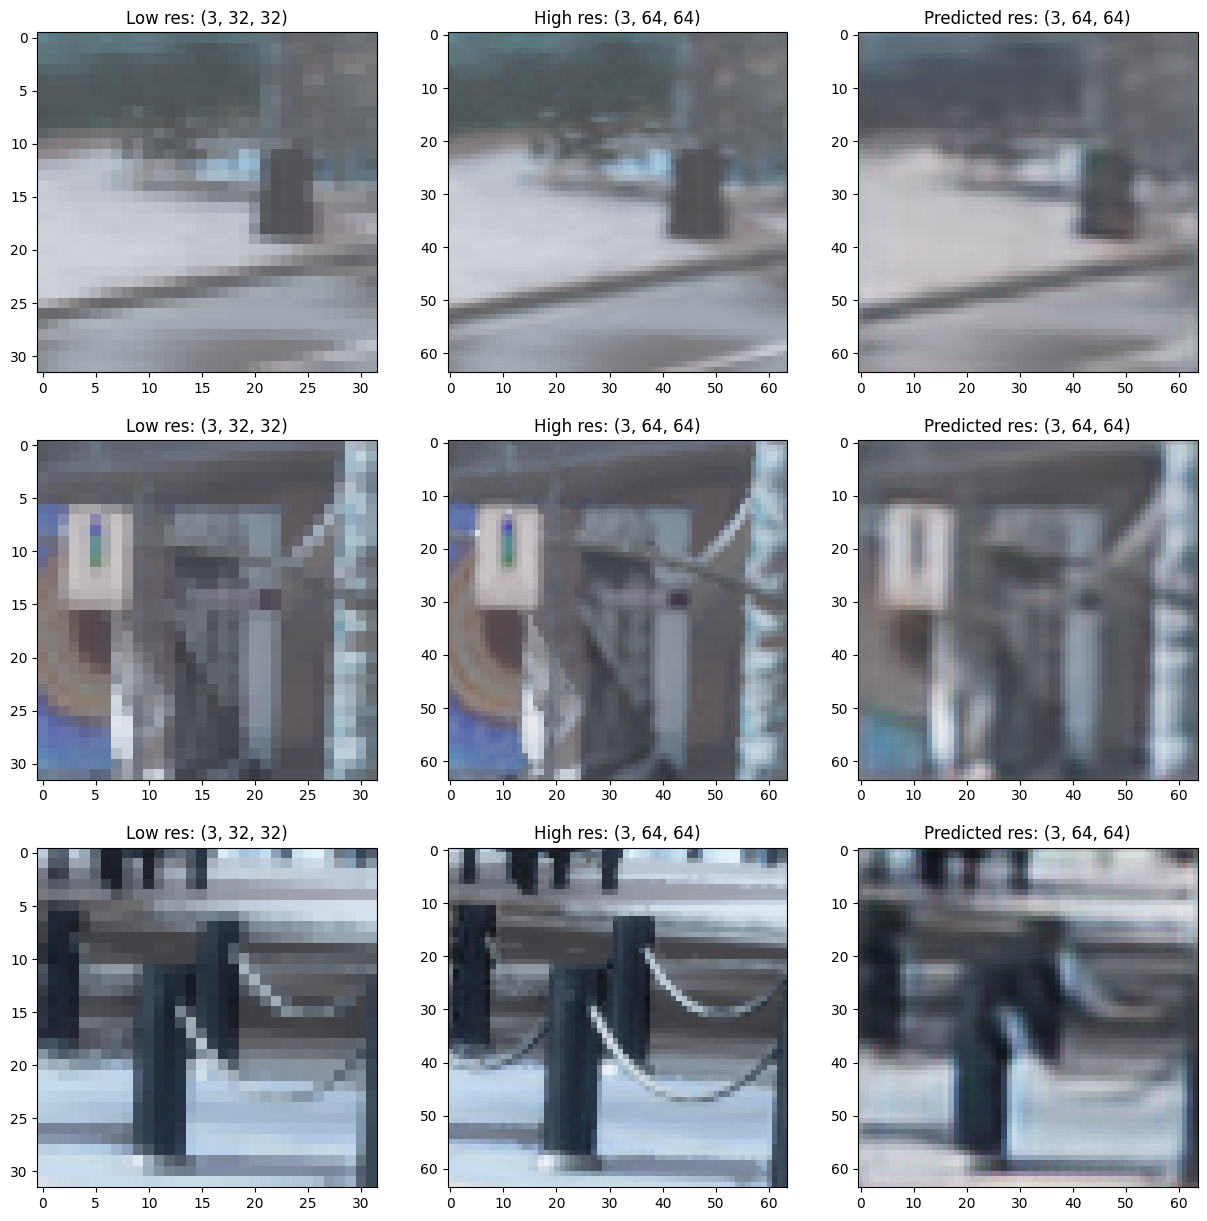

In [11]:
plot_images_from_model(exp, small_dataset, indices=[0, 1, 2])

# Training the data

In [12]:

# Take the sub part of the dataset from random indices
train_size = int(0.8 * len(X_train))
valid_size = len(X_train) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(X_train, [train_size, valid_size])

print("Size of train_dataset: ", len(train_dataset))
print("Size of valid_dataset: ", len(valid_dataset))

Size of train_dataset:  3200
Size of valid_dataset:  800


In [13]:
lr = 1e-3
batch_size = 32

torch.cuda.empty_cache()
r = RDN(C=6 , D=20, G=64, G0=64, scaling_factor=2, kernel_size=3, c_dims=X_train[0][0].shape[0], upscaling='shuffle', weights=None)
r = r.to(device)
adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
path = "results/superresol1000"
exp1 = nt.Experiment(r, train_dataset, valid_dataset, adam, stats_manager, device, criterion, batch_size=batch_size,
                     output_dir=path, perform_validation_during_training=True)

Start/Continue training from epoch 25
Finish training for 25 epochs


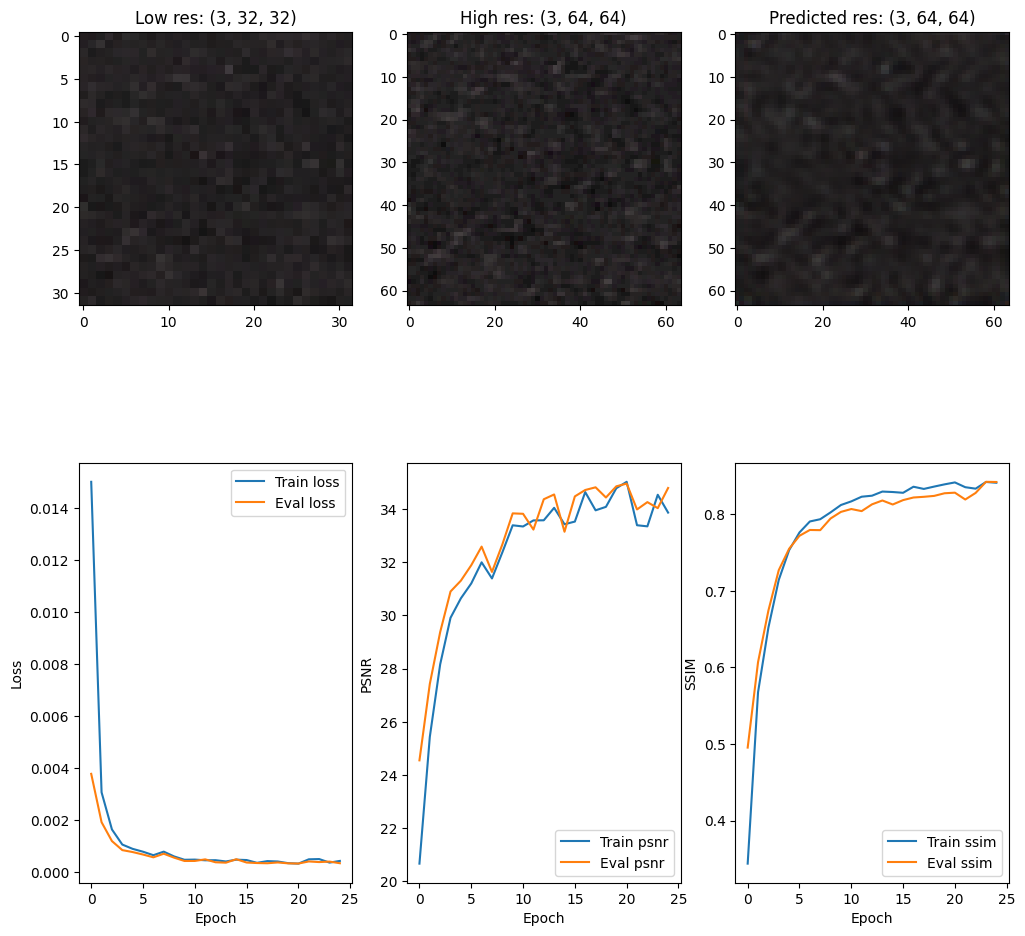

In [14]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 12))
exp1.run(num_epochs=25, plot=lambda exp: plot_images_and_metrics(exp, fig, axes, X_valid, np.random.randint(len(X_valid))))
#exp1.run(num_epochs=3, plot=None)

4
Chosen index 82760
Chosen index 71056
Chosen index 21511
Chosen index 52133


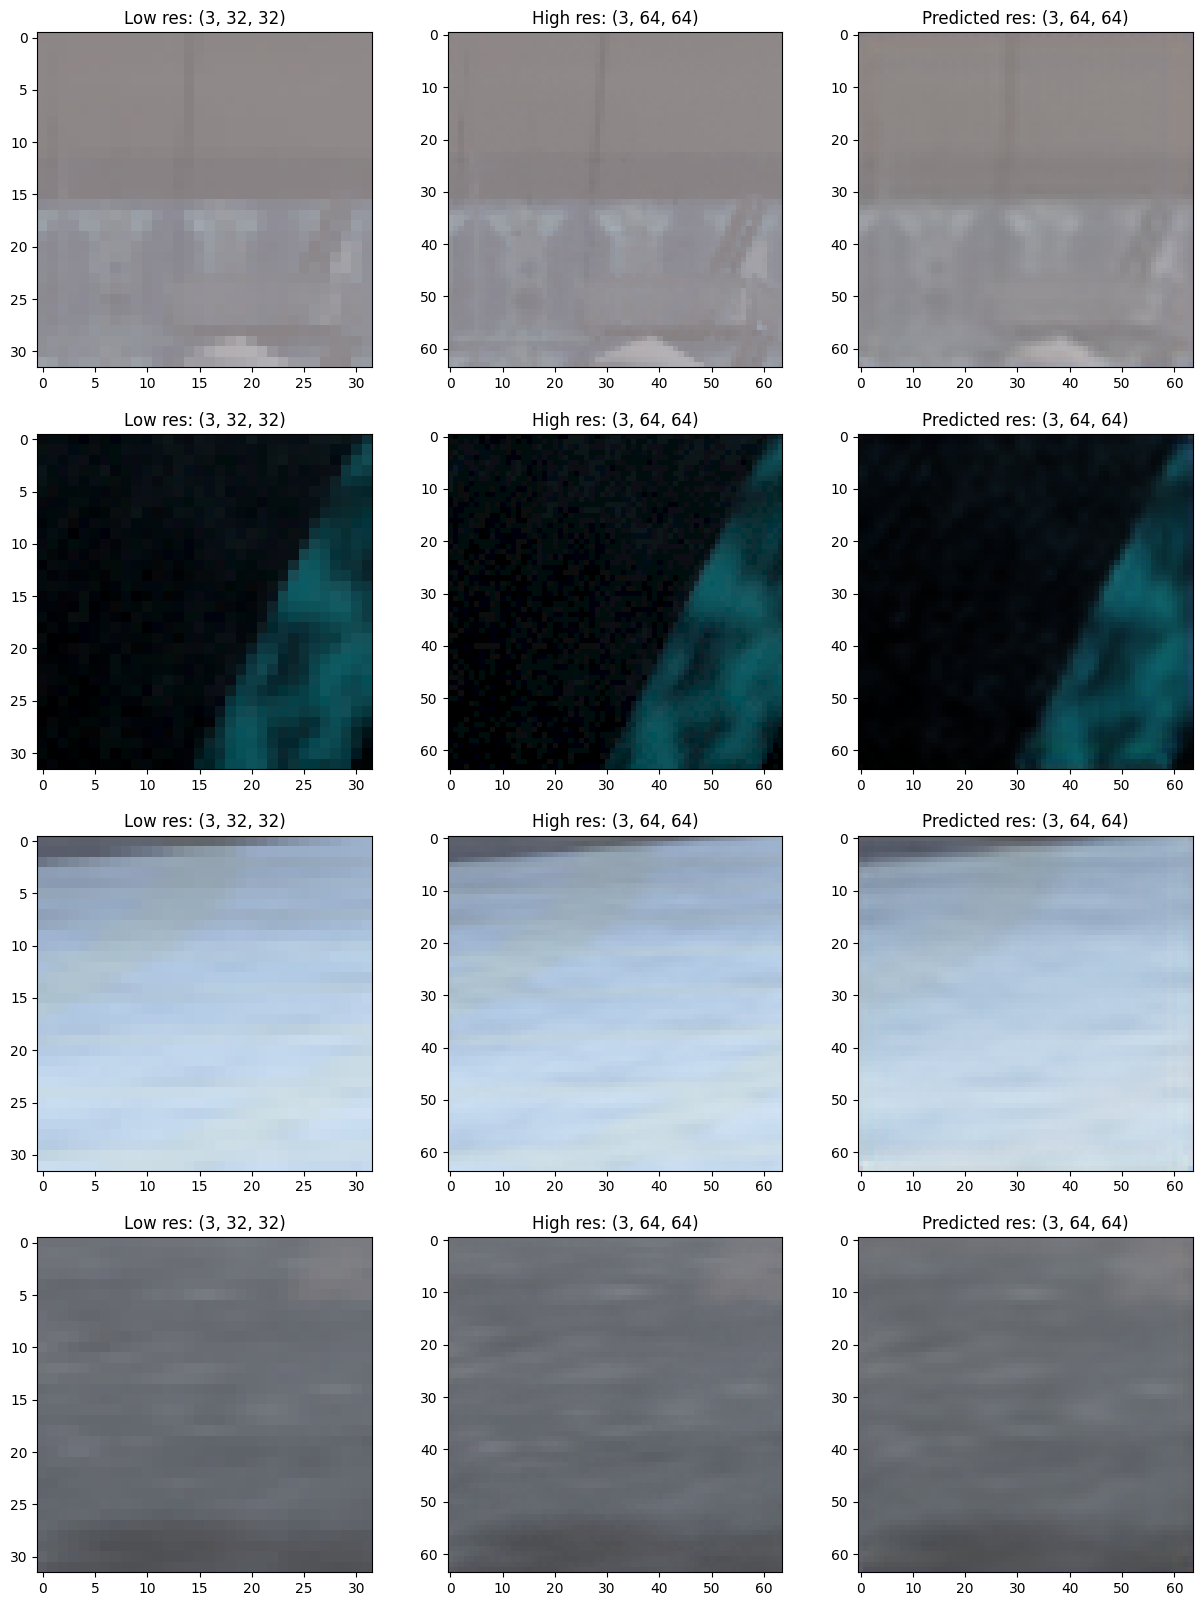

In [15]:
plot_images_from_model(exp1, X_valid, num_images=4)

4
Chosen index 10272
Chosen index 1595
Chosen index 13577
Chosen index 88909


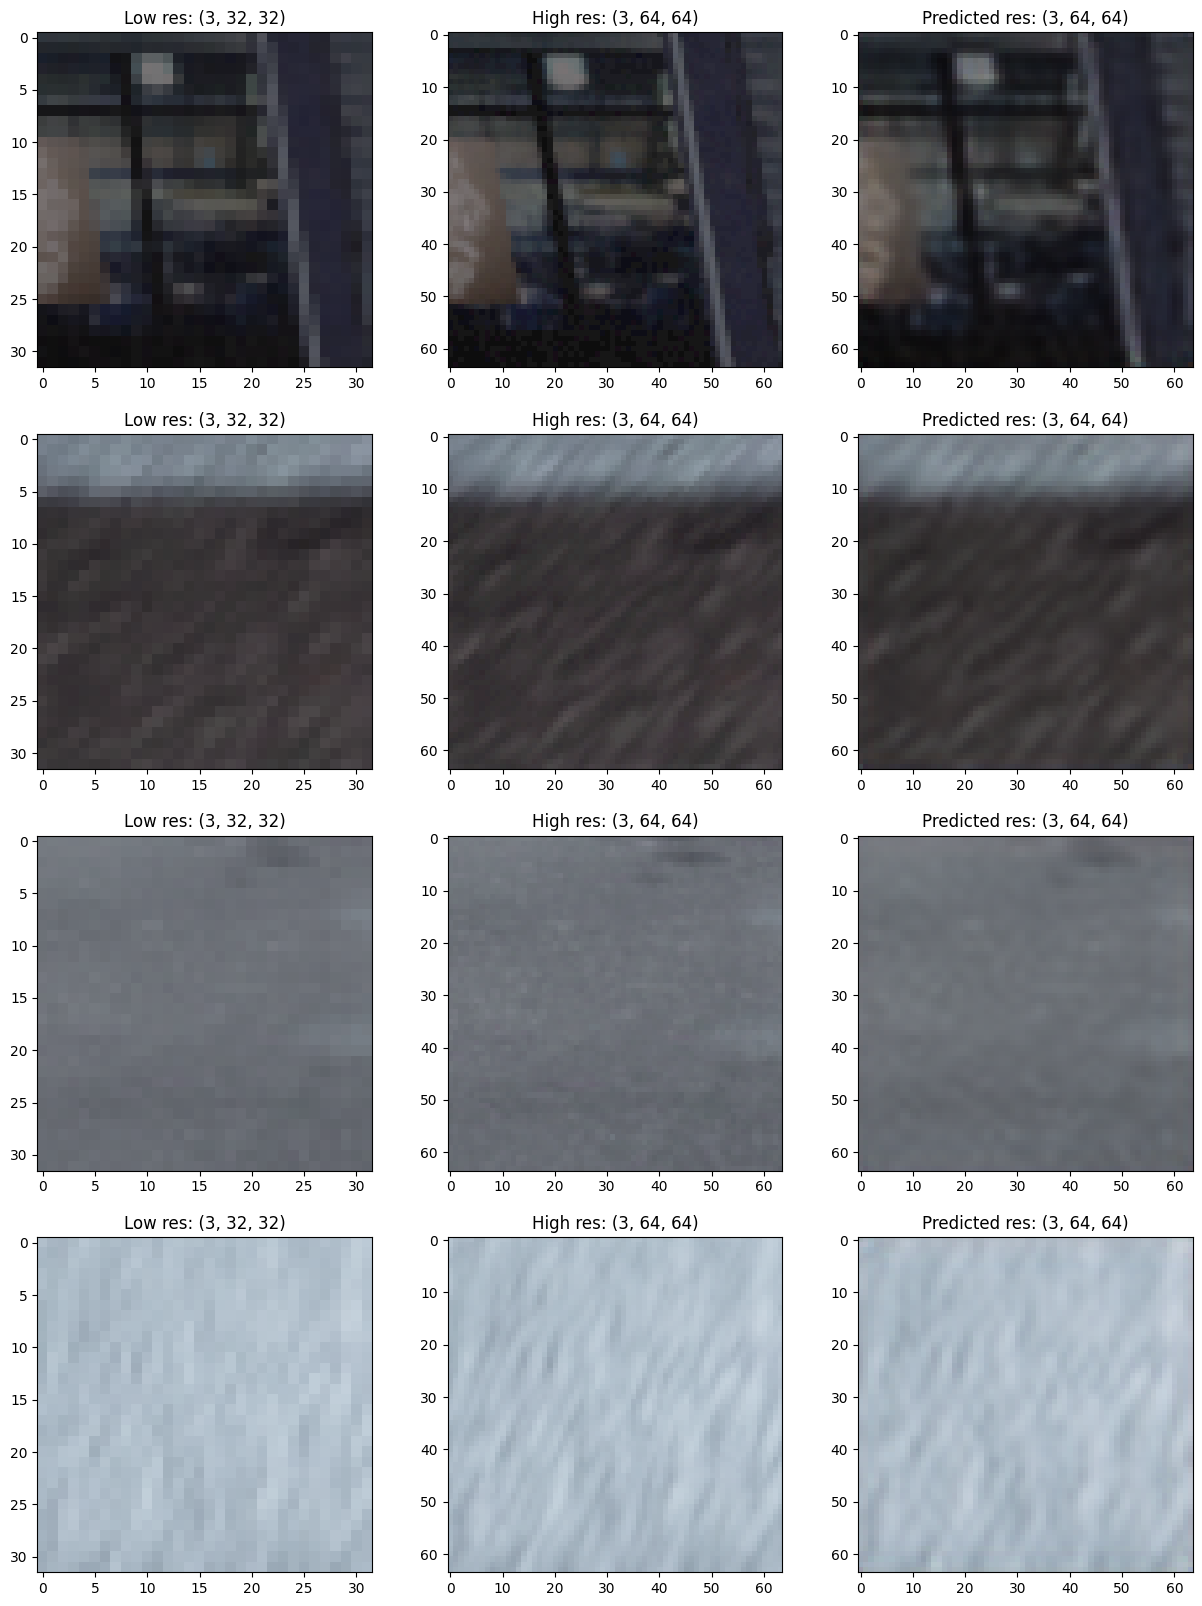

In [16]:
plot_images_from_model(exp1, X_valid, num_images=4)

## Reconstruct image from patch

In [17]:
import math

# Upscaling factor of this function is 2, so the predicted patch will be twice bigger
# Use a batch size of 32 to compute the predicted patch
def predict_full_image_by_patch(model, dest_width, dest_height, set, index, patch_size=32):
    scale_factor = 2
    predicted_image = np.zeros((dest_height, dest_width, 3))

    # Return a list of patch images
    low_res, high_res = set.get_all_patch_for_image(index)

    # Compute the number of patches in width and height
    num_patch_width = math.ceil(dest_width / scale_factor / patch_size)
    num_patch_height = math.ceil(dest_height / scale_factor / patch_size)
    num_patches = num_patch_width * num_patch_height
    
    batch_size = 128

    computed_patch = []
    
    for i in range(0, num_patches, batch_size):
        # Number of patch and batch size might not be divisible
        # So we need to take the min of the two
        num_patch_to_compute = min(batch_size, num_patches - i)
        torch_patches_numpy = low_res[i:i+num_patch_to_compute]
        torch_patches = torch.from_numpy(torch_patches_numpy)

        with torch.no_grad():
            torch.cuda.empty_cache()
            batch = torch_patches.to(device, dtype=torch.float32)
            predicted_batch = model.net(batch)

            # Append each patch individually after transformed to numpy
            for j in range(len(predicted_batch)):
                computed_patch.append(predicted_batch[j].detach().to('cpu').numpy())

    sf = 2  # Scaling factor

    print(len(computed_patch), num_patch_width * num_patch_height)

    for i in range(num_patch_height):
        for j in range(num_patch_width):
            patch_index = i * num_patch_width + j
            patch = computed_patch[patch_index].transpose(1, 2, 0)
            
            image_x_start = j * patch_size * sf
            image_x_end = (j + 1) * patch_size * sf

            if image_x_end > dest_width:
                image_x_end = dest_width
                image_x_start = dest_width - patch_size * sf

            image_y_start = i * patch_size * sf
            image_y_end = (i + 1) * patch_size * sf

            if image_y_end > dest_height:
                image_y_end = dest_height
                image_y_start = dest_height - patch_size * sf

            predicted_image[image_y_start:image_y_end, image_x_start:image_x_end, :] = patch


    return predicted_image

In [18]:
X_train.reset_dataset_limit()

index_train = np.random.randint(len(X_train))
index_test = np.random.randint(len(X_valid))

train_low_res, train_high_res = X_train.get_full_image(index_train)
test_low_res, test_high_res = X_train.get_full_image(index_test)

pred_high_res1 = predict_full_image_by_patch(exp1, 1920, 1080, X_train, index_train)
pred_high_res2 = predict_full_image_by_patch(exp1, 1920, 1080, X_valid, index_test)

510 510
510 510


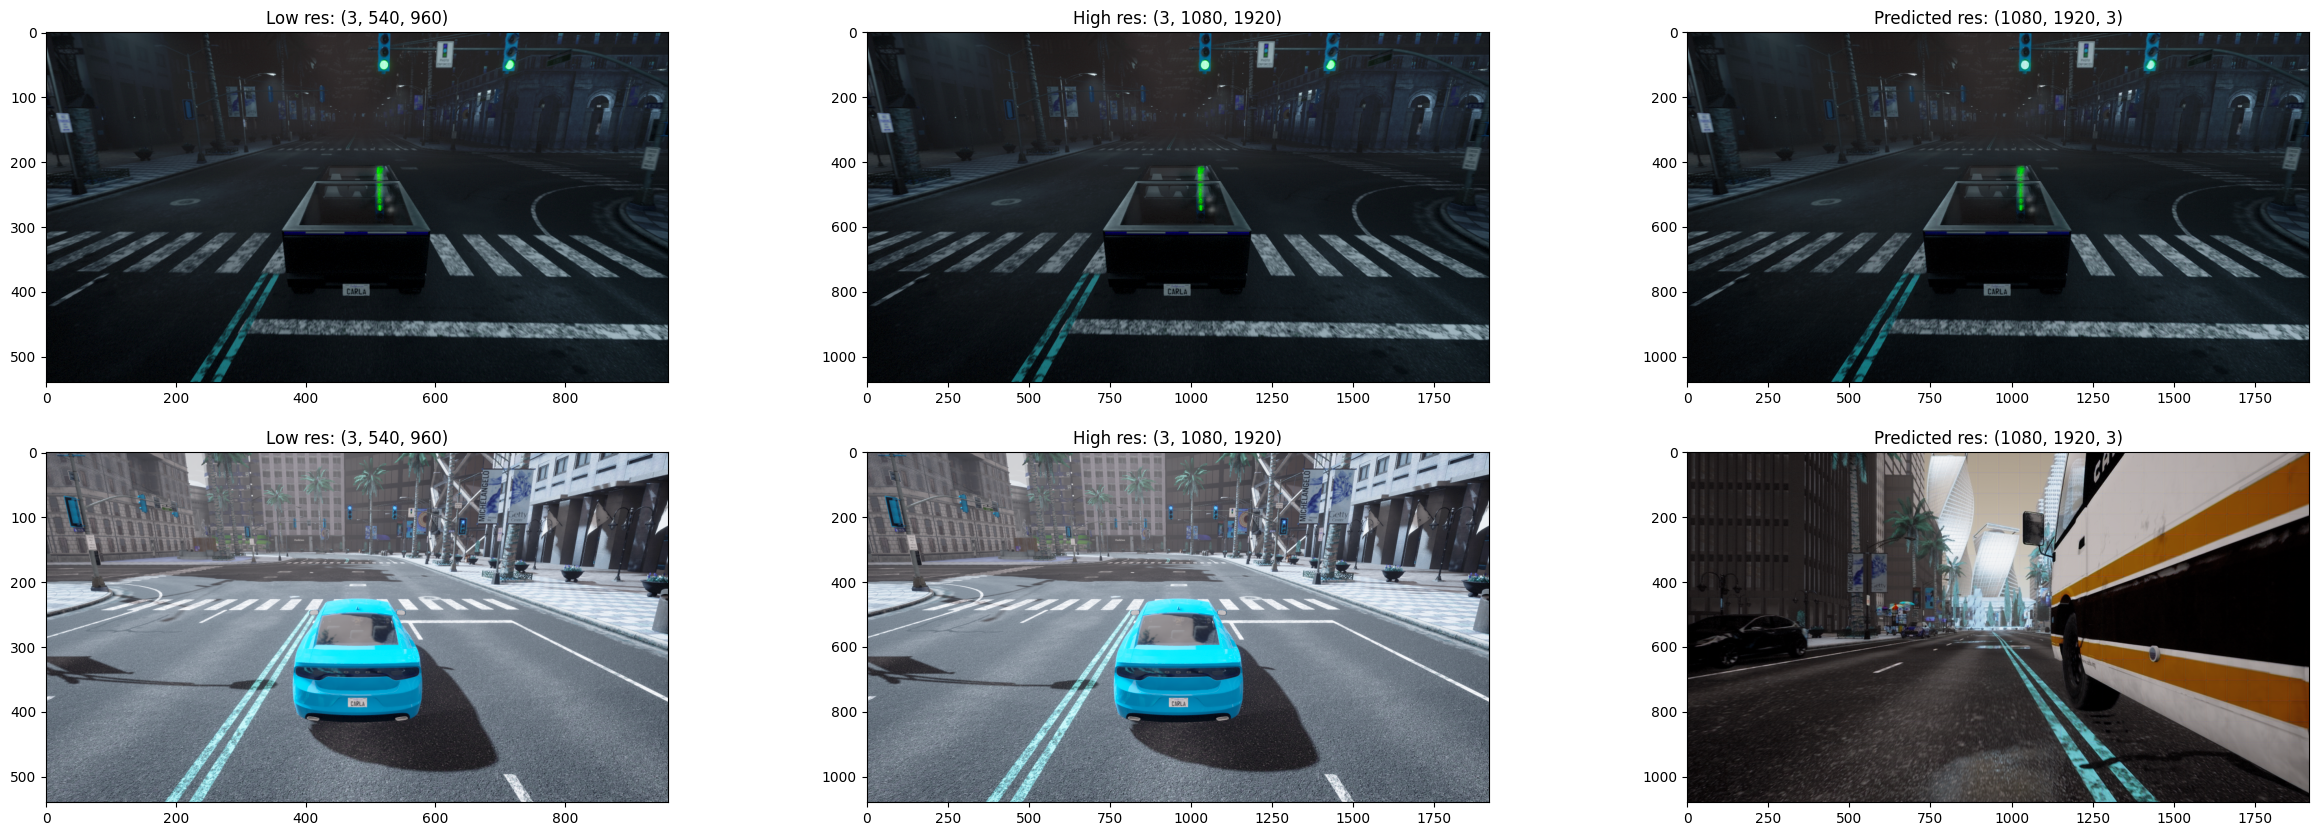

In [19]:
## Test on one image from the train and test set

fig, axes = plt.subplots(2, 3, figsize=(30, 10))

axes[0][0].set_title(f'Low res: {train_low_res.detach().cpu().numpy().shape}')
axes[0][1].set_title(f'High res: {train_high_res.detach().cpu().numpy().shape}')
axes[0][2].set_title(f'Predicted res: {pred_high_res1.shape}')

axes[0][0].imshow(train_low_res.detach().cpu().numpy().transpose(1, 2, 0))
axes[0][1].imshow(train_high_res.detach().cpu().numpy().transpose(1, 2, 0))
axes[0][2].imshow(pred_high_res1)

axes[1][0].set_title(f'Low res: {test_low_res.detach().cpu().numpy().shape}')
axes[1][1].set_title(f'High res: {test_high_res.detach().cpu().numpy().shape}')
axes[1][2].set_title(f'Predicted res: {pred_high_res2.shape}')

axes[1][0].imshow(test_low_res.detach().cpu().numpy().transpose(1, 2, 0))
axes[1][1].imshow(test_high_res.detach().cpu().numpy().transpose(1, 2, 0))
axes[1][2].imshow(pred_high_res2)

plt.show()

In [20]:
# Compute the PSNR and SSIM for the predicted image

print("PSNR for train image", metrics.peak_signal_noise_ratio(train_high_res.detach().cpu().numpy().transpose(1, 2, 0), pred_high_res1))
print("PSNR for test image", metrics.peak_signal_noise_ratio(test_high_res.detach().cpu().numpy().transpose(1, 2, 0), pred_high_res2))

print("SSIM for train image", metrics.structural_similarity(train_high_res.detach().cpu().numpy().transpose(1, 2, 0), pred_high_res1, win_size=7, data_range=1, multichannel=True, channel_axis=2))
print("SSIM for test image", metrics.structural_similarity(test_high_res.detach().cpu().numpy().transpose(1, 2, 0), pred_high_res2, win_size=7, data_range=1, multichannel=True, channel_axis=2))


/tmp/ipykernel_81298/515664618.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print("PSNR for train image", metrics.peak_signal_noise_ratio(train_high_res.detach().cpu().numpy().transpose(1, 2, 0), pred_high_res1))
/tmp/ipykernel_81298/515664618.py:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print("PSNR for test image", metrics.peak_signal_noise_ratio(test_high_res.detach().cpu().numpy().transpose(1, 2, 0), pred_high_res2))


PSNR for train image 37.144559898520875
PSNR for test image 8.534087839102867
SSIM for train image 0.9033787
SSIM for test image 0.18697393
